Bringing my 2d implementation here. this is the same as in B

In [2]:
#Recall my 2D implementation
import numpy as np
from scipy import signal, datasets
from scipy import fft, ndimage
from PIL import Image
import matplotlib.pyplot as plt
import time
import torch
from fft_conv_pytorch import fft_conv


def matrix_to_vector(input):
    input_h, input_w = input.shape
    output_vector = np.zeros(input_h * input_w, dtype=input.dtype) #output size for each matrix
    
    #flip the input matrix upside down because the last row should go first
    input = np.flipud(input)
    
    #flatten the matrix row by row into a vector
    for i, row in enumerate(input):
        st = i * input_w
        nd = st + input_w
        output_vector[st:nd] = row
    
    return output_vector

def vector_to_matrix(input, output_shape):
    output_h, output_w = output_shape
    output = np.zeros(output_shape, dtype=input.dtype)
    
    #reshape the vector into a matrix row by row
    for i in range(output_h):
        st = i * output_w
        nd = st + output_w
        output[i, :] = input[st:nd]
    
    #flip the output matrix upside down once again to get the correct result
    output = np.flipud(output)
    
    return output

def man_toeplitz(c, r=None): #c is the first column of the Toeplitz matrix, r is the first row of the Toeplitz matrix
    #convert c to a 1-D array
    c = np.asarray(c).flatten()
    if r is None:
        #if r is not given, use the conjugate of c
        r = np.conjugate(c)
    else:
        #convert r to a 1-D array
        r = np.asarray(r).flatten()   
    #first element of r is ignored
    r = r[1:]
    #frame of the Toeplitz matrix
    A = np.zeros((len(c), len(r) + 1), dtype=np.result_type(c[0], r[0]))
    #fill the first column
    A[:, 0] = c
    #fill the first row
    A[0, 1:] = r
    #rest of the matrix follows
    for i in range(1, len(c)):
        A[i, 1:] = A[i-1, :-1]
    
    return A

#example
print(man_toeplitz([1, 2, 3], [1, 4, 5, 6]))


def new_conv_mul(I, F): 
    I_row_num, I_col_num = I.shape 
    F_row_num, F_col_num = F.shape
    #calculate output dimensions
    output_row_num = I_row_num + F_row_num - 1
    output_col_num = I_col_num + F_col_num - 1
    print('output dimension:', output_row_num, output_col_num)
    # zero pad the filter just as before
    F_zero_padded = np.pad(F, ((output_row_num - F_row_num, 0),
                               (0, output_col_num - F_col_num)),
                            'constant', constant_values=0)

    #Use each row of the zero-padded F to create a toeplitz matrix. 
    #number of columns in this matrices are same as number of columns of input signal
    toeplitz_list = []
    for i in range(F_zero_padded.shape[0]-1, -1, -1): #iterate in reverse
        c = F_zero_padded[i, :] #i th row of the F 
        r = np.r_[c[0], np.zeros(I_col_num-1)] # first row for the toeplitz fuction should be defined similar to 1D approach otherwise# the result is wrong. This is the reason I couldn't use 1D function directly. 
        toeplitz_m = man_toeplitz(c,r) #new function used here
        toeplitz_list.append(toeplitz_m)
        print('F '+ str(i)+'\n', toeplitz_m)

        # doubly blocked toeplitz indices: 
    #  this matrix defines which toeplitz matrix from toeplitz_list goes to which part of the doubly blocked
    c = range(1, F_zero_padded.shape[0]+1)
    r = np.r_[c[0], np.zeros(I_row_num-1, dtype=int)]
    doubly_indices = man_toeplitz(c, r)

    ## create doubly blocked matrix with zero values
    toeplitz_shape = toeplitz_list[0].shape # shape of one toeplitz matrix
    h = toeplitz_shape[0]*doubly_indices.shape[0]
    w = toeplitz_shape[1]*doubly_indices.shape[1]
    doubly_blocked_shape = [h, w]
    doubly_blocked = np.zeros(doubly_blocked_shape)

    # tile toeplitz matrices for each row in the doubly blocked matrix
    b_h, b_w = toeplitz_shape # height and widths of each block
    for i in range(doubly_indices.shape[0]):
        for j in range(doubly_indices.shape[1]):
            start_i = i * b_h
            start_j = j * b_w
            end_i = start_i + b_h
            end_j = start_j + b_w
            doubly_blocked[start_i: end_i, start_j:end_j] = toeplitz_list[doubly_indices[i,j]-1]

    # convert I to a vector
    vectorized_I = matrix_to_vector(I)

    # get result of the convolution by matrix mupltiplication
    result_vector = np.matmul(doubly_blocked, vectorized_I)

    #reshape the raw rseult to desired matrix form
    out_shape = [output_row_num, output_col_num]
    output = vector_to_matrix(result_vector, out_shape)
    print('Result of implemented method: \n', output)
    
    return output

[[1 4 5 6]
 [2 1 4 5]
 [3 2 1 4]]


<h1> C. 4 </h1>

<h1> Please read the readMe in this folder for the source code of this implementation. The code used in this section is an implementation of the repository mentioned in the readMe. 

<br>

This section is focussing on analysis of existing optimised algorithms, rather than original implementations
 </h1>

Running Example case provided with fft_conv_pytorch

In [3]:
#Fast FFT Convolution in PyTorch. Example case provided

import torch
from fft_conv_pytorch import fft_conv, FFTConv1d

# Create dummy data.  
#     Data shape: (batch, channels, length)
#     Kernel shape: (out_channels, in_channels, kernel_size)
#     Bias shape: (out channels, )
# For ordinary 1D convolution, simply set batch=1.
signal = torch.randn(3, 3, 1024 * 1024)
kernel = torch.randn(2, 3, 128)
bias = torch.randn(2)

# Functional execution.  (Easiest for generic use cases.)
out = fft_conv(signal, kernel, bias=bias)

# Object-oriented execution.  (Requires some extra work, since the 
# defined classes were designed for use in neural networks.)
fft_conv = FFTConv1d(3, 2, 128, bias=True)
fft_conv.weight = torch.nn.Parameter(kernel)
fft_conv.bias = torch.nn.Parameter(bias)
out = fft_conv(signal)

In [4]:
print(out)

tensor([[[ 18.8442,   7.9674,   9.3242,  ...,   7.7109,  27.1303,   6.2552],
         [  0.4802, -12.4219,  22.4408,  ..., -30.8968,  19.1740, -15.4030]],

        [[ 31.2867, -11.6468,  -6.7972,  ..., -24.4035, -13.6146, -30.0700],
         [-15.4731,  17.1497,   5.9873,  ...,  24.4218, -16.3649,  -1.7942]],

        [[ 37.2240,  29.3589,  14.6674,  ..., -17.6309,  14.8463,   7.0910],
         [ 29.8304, -31.4979,  39.7694,  ...,  21.6118,   3.8925, -17.5259]]],
       grad_fn=<AddBackward0>)


<h1>Comparing runtime between fft_conv_pytorch (the fast net implementation), my 2D implementation and scipy.fft </h1>

Now comparing all 3 implementations for a gaussian blur

In [5]:
import torch
import numpy as np
import time
from fft_conv_pytorch import fft_conv
from scipy import fft
from PIL import Image
import matplotlib.pyplot as plt

# Load and resize the image using PIL
img = Image.open('scenic_pic.png').convert('L')
image_array = np.array(img.resize((200, 200))).astype(np.float32)  # Resized to 200x200
image_tensor = torch.tensor(image_array).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 200, 200)

# Gaussian Kernel for FFT Convolution
def gaussian_kernel(size, sigma):
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)
    d = np.sqrt(x**2 + y**2)
    gauss = np.exp(-(d**2 / (2.0 * sigma**2)))
    return gauss / np.sum(gauss)

kernel_size = 70
sigma = 8
gaussian_kernel_np = gaussian_kernel(kernel_size, sigma)
gaussian_kernel_tensor = torch.tensor(gaussian_kernel_np).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 70, 70)

# --- PyTorch FFT Convolution ---

# Time the PyTorch FFT convolution
start_fft_torch = time.time()

# Functional execution of fft convolution
output_fft_torch = fft_conv(image_tensor, gaussian_kernel_tensor, bias=None, padding='same')

end_fft_torch = time.time()
fft_torch_runtime = end_fft_torch - start_fft_torch

# Convert result back to numpy for comparison and resize to (200, 200)
fft_convolved_image_torch = output_fft_torch.squeeze().detach().numpy()
fft_convolved_image_torch = fft_convolved_image_torch[:200, :200]  # Crop to (200, 200)

# --- Manual 2D Convolution (Your Implementation) ---

start_manual = time.time()

manual_convolved_image = new_conv_mul(image_array, gaussian_kernel_np)

end_manual = time.time()
manual_runtime = end_manual - start_manual

# Crop manual result to (200, 200)
manual_convolved_image = manual_convolved_image[:200, :200]

# --- SciPy FFT Convolution ---

start_fft_scipy = time.time()

image_fft_scipy = fft.fft2(image_array)
kernel_fft_scipy = fft.fft2(gaussian_kernel_np, s=image_array.shape)
convolved_fft_scipy = fft.ifftshift(fft.ifft2(image_fft_scipy * kernel_fft_scipy))
fft_convolved_image_scipy = np.abs(convolved_fft_scipy)

end_fft_scipy = time.time()
fft_scipy_runtime = end_fft_scipy - start_fft_scipy

#SciPy result to (200, 200)
fft_convolved_image_scipy = fft_convolved_image_scipy[:200, :200]

output dimension: 269 269
F 268
 [[1.24588513e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.15244921e-11 1.24588513e-11 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.65934919e-11 2.15244921e-11 1.24588513e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.24588513e-11
  2.15244921e-11 3.65934919e-11]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.24588513e-11 2.15244921e-11]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.24588513e-11]]
F 267
 [[2.15244921e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.71867155e-11 2.15244921e-11 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.32206217e-11 3.71867155e-11 2.15244921e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.15244

PyTorch FFT convolution runtime: 0.0036 seconds
Manual 2D convolution runtime: 10.6135 seconds
SciPy FFT convolution runtime: 0.0040 seconds
MSE between PyTorch FFT and Manual convolution: 5422.749088
MSE between SciPy FFT and Manual convolution: 5667.938026


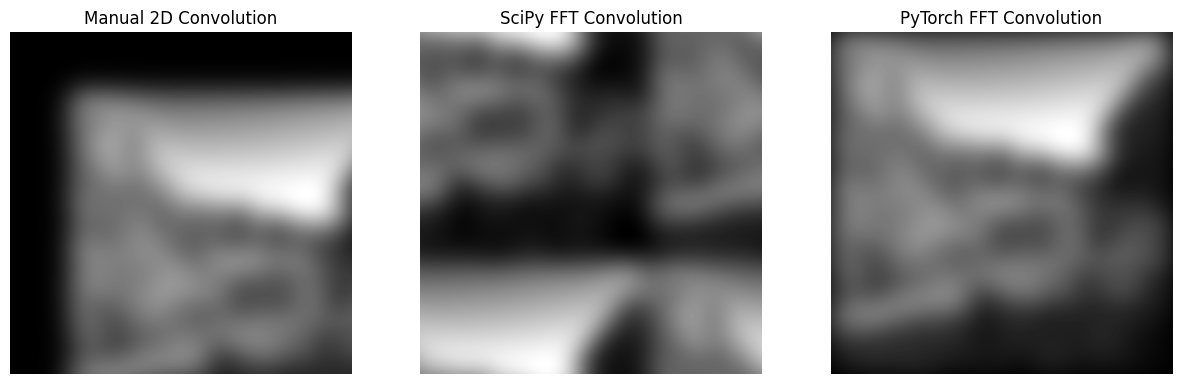

In [6]:
def manual_mse(image1, image2):
    diff = image1 - image2
    squared_diff = np.square(diff)
    mse_value = np.mean(squared_diff)
    return mse_value

#Calculate MSE
mse_fft_torch = manual_mse(fft_convolved_image_torch, manual_convolved_image)
mse_fft_scipy = manual_mse(fft_convolved_image_scipy, manual_convolved_image)

# --- Print runtime and accuracy (MSE) ---
print(f"PyTorch FFT convolution runtime: {fft_torch_runtime:.4f} seconds")
print(f"Manual 2D convolution runtime: {manual_runtime:.4f} seconds")
print(f"SciPy FFT convolution runtime: {fft_scipy_runtime:.4f} seconds")

print(f"MSE between PyTorch FFT and Manual convolution: {mse_fft_torch:.6f}")
print(f"MSE between SciPy FFT and Manual convolution: {mse_fft_scipy:.6f}")

# --- Visualization ---

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(manual_convolved_image, cmap='gray')
axes[0].set_title('Manual 2D Convolution')
axes[0].axis('off')

axes[1].imshow(fft_convolved_image_scipy, cmap='gray')
axes[1].set_title('SciPy FFT Convolution')
axes[1].axis('off')

axes[2].imshow(fft_convolved_image_torch, cmap='gray')
axes[2].set_title('PyTorch FFT Convolution')
axes[2].axis('off')

plt.show()


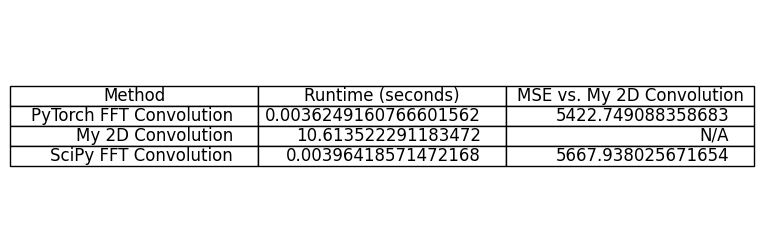

In [7]:
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Data for table
data = [
    ["PyTorch FFT Convolution", fft_torch_runtime, mse_fft_torch],
    ["My 2D Convolution", manual_runtime, "N/A"],
    ["SciPy FFT Convolution", fft_scipy_runtime, mse_fft_scipy]
]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('tight')
ax.axis('off')

# Create a table
table = ax.table(cellText=data, colLabels=["Method", "Runtime (seconds)", "MSE vs. My 2D Convolution"], loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.show()


<h2>The Pytorch FFT is as fast as scipy.fft for inputs and kernels of this size. My implementation will tap out with any bigger image. So, let's compare scipy and pytorch for arbritarily larger inputs </h2>

In [12]:
from scipy import signal

Testing with image size: 128x128
Testing with image size: 256x256
Testing with image size: 512x512
Testing with image size: 1024x1024
Testing with image size: 2048x2048


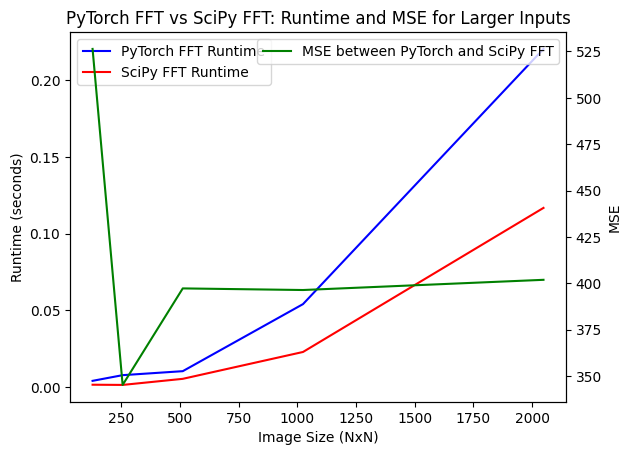

In [11]:
#Function to generate progressively larger random images and kernels
def generate_test_data(size, kernel_size, sigma=8):
    # Generate random image
    image = np.random.randn(size, size).astype(np.float32)
    
    # Generate Gaussian kernel using scipy's signal.windows.gaussian
    gaussian_window = signal.windows.gaussian(kernel_size, sigma)
    kernel = np.outer(gaussian_window, gaussian_window).astype(np.float32)
    
    return image, kernel

#compare PyTorch and SciPy FFT convolution
def compare_fft_convolutions(image_size_list, kernel_size):
    runtimes_pytorch = []
    runtimes_scipy = []
    mses = []

    for size in image_size_list:
        print(f"Testing with image size: {size}x{size}")

        image, kernel = generate_test_data(size, kernel_size)

        #----- PyTorch FFT convolution -------------
        image_tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0) 
        kernel_tensor = torch.tensor(kernel).unsqueeze(0).unsqueeze(0) 

        start_pytorch = time.time()
        output_fft_torch = fft_conv(image_tensor, kernel_tensor, bias=None, padding='same')
        end_pytorch = time.time()

        fft_convolved_image_torch = output_fft_torch.squeeze().detach().numpy()

        # append runtime for PyTorch after each iteration
        runtimes_pytorch.append(end_pytorch - start_pytorch)

        #-------SciPy FFT convolution---------
        start_scipy = time.time()
        image_fft_scipy = fft.fft2(image)
        kernel_fft_scipy = fft.fft2(kernel, s=image.shape)
        convolved_fft_scipy = fft.ifftshift(fft.ifft2(image_fft_scipy * kernel_fft_scipy))
        fft_convolved_image_scipy = np.abs(convolved_fft_scipy)
        end_scipy = time.time()

        # append runtime for SciPy
        runtimes_scipy.append(end_scipy - start_scipy)

        #MSE between PyTorch and SciPy results
        mse_value = np.mean((fft_convolved_image_torch - fft_convolved_image_scipy) ** 2)
        mses.append(mse_value)

    return runtimes_pytorch, runtimes_scipy, mses

#sizes to test
image_sizes = [128, 256, 512, 1024, 2048]

runtimes_pytorch, runtimes_scipy, mses = compare_fft_convolutions(image_sizes, kernel_size=70)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Image Size (NxN)')
ax1.set_ylabel('Runtime (seconds)')
ax1.plot(image_sizes, runtimes_pytorch, 'b-', label='PyTorch FFT Runtime')
ax1.plot(image_sizes, runtimes_scipy, 'r-', label='SciPy FFT Runtime')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('MSE')
ax2.plot(image_sizes, mses, 'g-', label='MSE between PyTorch and SciPy FFT')
ax2.legend(loc='upper right')

plt.title('PyTorch FFT vs SciPy FFT: Runtime and MSE for Larger Inputs')
plt.show()


<h3> This is surprising as the benchmarks claimed by the author was that with larger inputs, the pytorch fft implementation should be faster </h3>

<h1> D. 5 Let's investigate why this is by ivestigating the source code
 </h1>

<h2>After going through the source code for the pytorch fft implementation and scipy fft implementation, these are some of the reasons I could see as to why I was unable to utilise the full capabilities of the pytorch implementation: </h2>

1. Most noticibly, hardware utilization: (CPU vs GPU) seems to be the most pivotal factor:

PyTorch is designed to leverage CUDA for faster matrix operations and convolutional calculations.
On a GPU, PyTorch FFT might outperform SciPy for larger inputs because the underlying matrix operations would be highly parallelized.

SciPy is highly optimized for CPU-based operations as it uses FFTW for fast Fourier transforms on the CPU.

<br>
 scipy.fft uses Bluestein’s algorithm and so is never worse than O(n log n).


2. Overhead from Additional Functionality:

PyTorch provides a lot of flexibility for different convolutional layers. It supports grouping, dilation, and bias. This flexibility possibly introduces some overhead, especially for operations like padding and handling various data shapes (as seen in the provided PyTorch source code linked in the readMe).
In contrast, SciPy's FFT convolution doesn’t have to deal with complexities like backpropagation, or additional nuances that I just mentioned. 
<br>
Additionally, in the PyTorch implementation, tensors are reshaped and moved between dimensions several times to handle complex-valued matrix multiplications (complex_matmul in line 11). 
SciPy avoids such overhead because it works directly with NumPy arrays.

3. Memory Management and Padding:

SciPy also uses padding, but it seems that PyTorch's memory management is slightly more complex.



In [1]:
#here are some key parts of the code that justify my above claims:

'''The complexity and flexibility in pytorch's souce code, which scipy lacks

def fft_conv(
    signal: Tensor,
    kernel: Tensor,
    padding: Union[int, Iterable[int], str] = 0,
    padding_mode: str = "constant",
    stride: Union[int, Iterable[int]] = 1,
    dilation: Union[int, Iterable[int]] = 1,
    groups: int = 1,
):
    ...
    # Pad the kernel internally according to the dilation parameters
    kernel = torch.kron(kernel, offset)[(slice(None), slice(None)) + cutoff]

    # Pad the input signal & kernel tensors
    signal_padding = [r(p) for p in padding_[::-1] for r in (floor, ceil)]
    signal = f.pad(signal, signal_padding, mode=padding_mode)


    def complex_matmul(a: Tensor, b: Tensor, groups: int = 1) -> Tensor:
    a = a.view(a.size(0), groups, -1, *a.shape[2:])
    b = b.view(groups, -1, *b.shape[1:])
    
    a = torch.movedim(a, 2, a.dim() - 1).unsqueeze(-2)
    b = torch.movedim(b, (1, 2), (b.dim() - 1, b.dim() - 2))

    # complex value matrix multiplication
    real = a.real @ b.real - a.imag @ b.imag
    imag = a.imag @ b.real + a.real @ b.imag

'''

'The complexity and flexibility in pytorch\'s souce code, which scipy lacks\n\ndef fft_conv(\n    signal: Tensor,\n    kernel: Tensor,\n    padding: Union[int, Iterable[int], str] = 0,\n    padding_mode: str = "constant",\n    stride: Union[int, Iterable[int]] = 1,\n    dilation: Union[int, Iterable[int]] = 1,\n    groups: int = 1,\n):\n    ...\n    # Pad the kernel internally according to the dilation parameters\n    kernel = torch.kron(kernel, offset)[(slice(None), slice(None)) + cutoff]\n\n    # Pad the input signal & kernel tensors\n    signal_padding = [r(p) for p in padding_[::-1] for r in (floor, ceil)]\n    signal = f.pad(signal, signal_padding, mode=padding_mode)\n\n\n    def complex_matmul(a: Tensor, b: Tensor, groups: int = 1) -> Tensor:\n    a = a.view(a.size(0), groups, -1, *a.shape[2:])\n    b = b.view(groups, -1, *b.shape[1:])\n    \n    a = torch.movedim(a, 2, a.dim() - 1).unsqueeze(-2)\n    b = torch.movedim(b, (1, 2), (b.dim() - 1, b.dim() - 2))\n\n    # complex value